## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

/Users/raph/opt/anaconda3/envs/mlab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [3]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [4]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

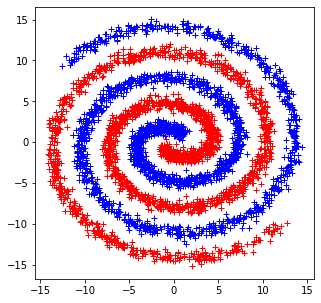

In [5]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [6]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just two layers. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [26]:
from typing_extensions import Literal

# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self, layers=[2, 10,1], non_linearity : Literal["relu", "sigmoid", "tanh"] = "relu"):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        sequence = [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        non_lin = nn.ReLU() if non_linearity == "relu" else nn.Sigmoid()
        non_lin  = nn.Tanh() if non_linearity == "tanh" else non_lin
        sequence_with_non_lin = []
        for lin in sequence :
            sequence_with_non_lin.append(lin)
            sequence_with_non_lin.append(non_lin)

        self.seq = nn.Sequential(
            *sequence_with_non_lin[:-1]
        )
     
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        h = self.seq(inputs)
        outputs = torch.sigmoid(h)
        
        return outputs

In [27]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [30]:
# define a function for training
from tqdm.autonotebook import tqdm

def train(num_epochs, batch_size, criterion, optimizer, model, dataset, verbose=0):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in tqdm(range(num_epochs)):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [31]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Text(0.5, 1.0, 'Visualization of convergence')

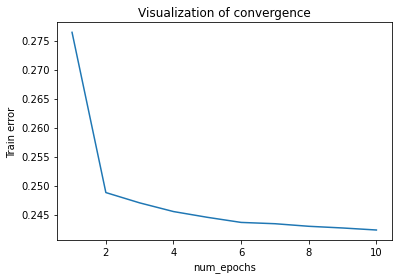

In [12]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [13]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [14]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
    #loss = criterion(y_val, y_pre.float())
    #print(loss.item())

In [36]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))
    return acc.item()

In [16]:
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 59.00 %


In [18]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

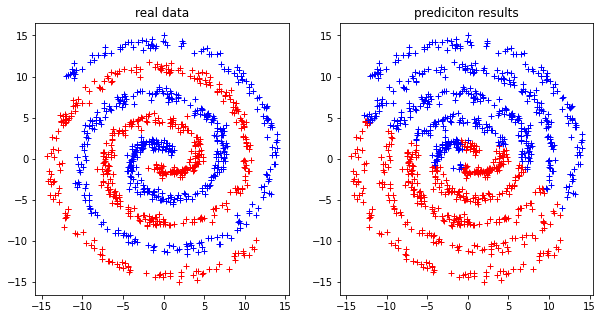

In [19]:
compare_pred(X_val, y_val, y_pre)

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(500)

In [49]:
from typing_extensions import TypedDict
from typing import Any
import pandas as pd

class HPRange(TypedDict):
    hp_list : list
    hp_default : Any


hyperparameters = {
    "layers" : HPRange(hp_list=[[2, 10, 1],[2, 32, 1],[2, 512, 1],[2, 2048, 1], 
                                [2, 10, 10, 1], [2, 10, 10, 10, 1]],
                       hp_default=[2, 10, 10, 1]),
    "num_epochs" : HPRange(hp_list=[10, 50, 100], hp_default=50),
    "non_linearity": HPRange(hp_list=["sigmoid", "tanh"], hp_default='relu'),
    "batch_size" : HPRange(hp_list=[32, 128, 400], hp_default=10),
    "optimizer_algo" : HPRange(hp_list=[torch.optim.RMSprop, torch.optim.Adam], hp_default=torch.optim.SGD),
}

def eval_hp_end2end(*, num_epochs, batch_size, non_linearity, layers, optimizer_algo):
    criterion = nn.MSELoss()
    model = Model(layers=layers, non_linearity=non_linearity)
    optimizer = optimizer_algo(model.parameters(), lr=0.01)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

    # predict labels for validation set
    model.eval() 
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
        #loss = criterion(y_val, y_pre.float())
        #print(loss.item())

    return accuracy(y_val, y_pre)

from copy import deepcopy

defaults_params = {name: hprange["hp_default"] for name, hprange in hyperparameters.items() }

list_results = []

for hp_name, hp_range in hyperparameters.items():
    for hp in hp_range["hp_list"]:
        copy_default = deepcopy(defaults_params)
        copy_default[hp_name] = hp
        print(copy_default)
        acc = eval_hp_end2end(**copy_default)
        copy_default["acc"] = acc
        copy_default["hp_name"] = hp_name
        list_results.append(copy_default)




{'layers': [2, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


Accuracy of the network on the 1000 validation data: 57.90 %
{'layers': [2, 32, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Accuracy of the network on the 1000 validation data: 58.60 %
{'layers': [2, 512, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Accuracy of the network on the 1000 validation data: 57.70 %
{'layers': [2, 2048, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Accuracy of the network on the 1000 validation data: 64.50 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Accuracy of the network on the 1000 validation data: 57.80 %
{'layers': [2, 10, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


Accuracy of the network on the 1000 validation data: 61.10 %
{'layers': [2, 10, 10, 1], 'num_epochs': 10, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Accuracy of the network on the 1000 validation data: 60.40 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


Accuracy of the network on the 1000 validation data: 59.90 %
{'layers': [2, 10, 10, 1], 'num_epochs': 100, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Accuracy of the network on the 1000 validation data: 58.70 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'sigmoid', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Accuracy of the network on the 1000 validation data: 59.00 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'tanh', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


Accuracy of the network on the 1000 validation data: 60.40 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 32, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


Accuracy of the network on the 1000 validation data: 56.80 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 128, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:01<00:00, 32.47it/s]


Accuracy of the network on the 1000 validation data: 57.80 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 400, 'optimizer_algo': <class 'torch.optim.sgd.SGD'>}


100%|██████████| 50/50 [00:01<00:00, 38.26it/s]


Accuracy of the network on the 1000 validation data: 52.70 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.rmsprop.RMSprop'>}


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Accuracy of the network on the 1000 validation data: 96.80 %
{'layers': [2, 10, 10, 1], 'num_epochs': 50, 'non_linearity': 'relu', 'batch_size': 10, 'optimizer_algo': <class 'torch.optim.adam.Adam'>}


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]

Accuracy of the network on the 1000 validation data: 92.10 %


,layers,num_epochs,non_linearity,batch_size,optimizer_algo,acc,hp_name
0,"[2, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.579,layers
1,"[2, 32, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.586,layers
2,"[2, 512, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.577,layers
3,"[2, 2048, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.645,layers
4,"[2, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.578,layers
5,"[2, 10, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.611,layers
6,"[2, 10, 10, 1]",10,relu,10,<class 'torch.optim.sgd.SGD'>,0.604,num_epochs
7,"[2, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.599,num_epochs
8,"[2, 10, 10, 1]",100,relu,10,<class 'torch.optim.sgd.SGD'>,0.587,num_epochs
9,"[2, 10, 10, 1]",50,sigmoid,10,<class 'torch.optim.sgd.SGD'>,0.590,non_linearity


In [50]:
pd.DataFrame(list_results).set_index("hp_name")

,layers,num_epochs,non_linearity,batch_size,optimizer_algo,acc
hp_name,,,,,,
layers,"[2, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.579
layers,"[2, 32, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.586
layers,"[2, 512, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.577
layers,"[2, 2048, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.645
layers,"[2, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.578
layers,"[2, 10, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.611
num_epochs,"[2, 10, 10, 1]",10,relu,10,<class 'torch.optim.sgd.SGD'>,0.604
num_epochs,"[2, 10, 10, 1]",50,relu,10,<class 'torch.optim.sgd.SGD'>,0.599
num_epochs,"[2, 10, 10, 1]",100,relu,10,<class 'torch.optim.sgd.SGD'>,0.587
